In [1]:
import timeit
import datetime as dt
import os
import subprocess 

import pandas as pd
import numpy as np

#for portofolio optimization 
import scipy.optimize as sco


#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
%matplotlib inline
#visualization with seaborn
import seaborn as sns
#visualization with plotly 
import plotly.graph_objects as go #for candle chart visualization
import plotly.express as px #for html output


#to get financial data
from pandas_datareader import data as pdr


#for webscraping 
import requests
from bs4 import BeautifulSoup 
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import requests


#for pdf report generation
from reportlab.pdfgen import canvas
from reportlab.platypus import *
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus.tableofcontents import TableOfContents


/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
days_to_lookback = int (input('days to search financial data:'))

days to search financial data:30


In [3]:
riskfree = .0019

In [4]:
date_end = dt.datetime.now() #.today()
date_start = date_end - dt.timedelta(days_to_lookback)

# Create timestamped folder to save reports created later

In [5]:
#timestamp = str(dt.datetime.now()) <- '2020-06-26 20:26:08.775766'  
timestamp =  dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
timestamp

'2020-07-04 21-43-25'

In [6]:
path = os.getcwd() 
reportDir = os.path.join(path,timestamp)
reportDir

'/Users/reejungkim/Documents/Git/reporting automation/2020-07-04 21-43-25'

In [7]:
#create named folder
os.makedirs(reportDir, exist_ok = False)

In [8]:
os.chdir(reportDir)

# Web scraping S&P100 companies from Wikipedia table

In [9]:
website_url = requests.get("https://en.wikipedia.org/wiki/S%26P_100").text

soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

In [10]:
wiki_table = soup.find('table',{'class':'wikitable sortable'})

In [11]:
data = []
tHeader = []
SP100_tickers = pd.DataFrame()

for tr in wiki_table.find_all("tr"):
    for th in tr.find_all("th")[:1]:
        tHeader = th.get_text(strip=True)
        SP100_tickers[tHeader] = []
    for td in tr.find_all("td")[:1]:
        data.append( td.get_text(strip=True))
        
SP100_tickers[tHeader] = data

In [12]:
SP100_tickers

,Symbol
0,AAPL
1,ABBV
2,ABT
3,ACN
4,ADBE
...,...
96,VZ
97,WBA
98,WFC
99,WMT


# Use DataReader to get financial data of S&P100 companies from yahoo

In [13]:
%%time

df = pd.DataFrame()

for i in data:
    symbol = SP100_tickers.loc[SP100_tickers['Symbol']==i]
    try:
        symbol_data = pdr.DataReader(i, 'yahoo', date_start, date_end).reset_index()
        #display(symbol_data)  
    except (KeyError, ValueError):  # the error could possibly occur when there's "." in stock name 
        symbol_data = pdr.DataReader(i.replace('.','-'), 'yahoo', date_start, date_end).reset_index()
        #symbol_data = pd.DataFrame()
        pass
    except:
        print(i + " - Error.")
        symbol_data = pd.DataFrame()
        pass
    single_table = pd.concat([symbol, symbol_data], axis=0, ignore_index=True) #axis=0 <- row. add frames by row and use fill down.
    single_table['Symbol'].ffill(inplace=True)
    df = df.append(single_table)
    

CPU times: user 7.18 s, sys: 629 ms, total: 7.81 s
Wall time: 1min 1s


In [14]:
df = df.loc[df['Date'].notnull()]

In [15]:
df = df.reset_index(drop=True)

df.groupby(['Symbol']).describe().transpose()

In [16]:
df_Flat = df

### volatility

In [283]:
d = df.pivot_table(values='Close', index='Date', columns='Symbol', aggfunc=np.sum, margins=False)

In [284]:
logChange = np.log(d / d.shift(1)) # geometric brownian motion. - make the errors being normally distributed.
# more standardly used than pct_change.  df_temp['Close'] in this case.
logChange

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-08,0.005895,0.007854,0.029604,0.013293,0.012344,0.081311,0.014309,0.000354,0.007484,0.016401,...,-0.007629,-0.017300,0.035010,0.026550,-0.000050,0.006043,0.036163,0.050788,-0.002636,0.030794
2020-06-09,0.031090,0.016566,-0.025052,-0.018824,-0.001560,-0.044060,-0.035970,-0.003772,-0.004205,0.029973,...,-0.000873,-0.019455,-0.024007,-0.032943,-0.002609,-0.003967,-0.037708,-0.020926,0.000907,-0.022539
2020-06-10,0.025402,0.007562,0.020721,0.010030,0.024032,-0.070812,-0.011989,0.009823,-0.001582,0.017755,...,-0.011253,-0.015442,-0.011191,-0.068314,0.007008,0.003278,-0.022332,-0.093748,-0.001567,-0.055116
2020-06-11,-0.049201,-0.049069,-0.048693,-0.066530,-0.048216,-0.106436,-0.073113,-0.036864,-0.053529,-0.034387,...,-0.074745,-0.071712,-0.059506,-0.084333,-0.059603,-0.027949,-0.083077,-0.103455,-0.008871,-0.092392
2020-06-12,0.008596,0.002165,0.014027,0.028376,0.047528,0.044245,0.009554,-0.004579,0.025787,-0.005072,...,0.004992,0.017544,0.010003,0.037207,0.017737,0.001416,0.015825,0.043104,-0.019763,0.021211
2020-06-15,0.012291,0.006683,0.005936,-0.008969,-0.012873,0.004530,0.022013,0.008591,0.016943,0.010810,...,0.003955,0.010476,0.040175,0.033297,-0.002604,-0.006745,0.002172,0.008544,0.002884,-0.000636
2020-06-16,0.026157,0.031514,0.002119,0.022812,0.025413,0.003008,0.013100,0.031750,0.008686,0.016419,...,0.023202,0.017941,0.001797,0.014337,0.005824,0.013620,0.015782,0.010929,0.013208,0.022237
2020-06-17,-0.001393,-0.003337,0.012843,0.003906,0.004411,-0.030809,-0.011874,-0.003975,-0.003064,0.009783,...,-0.001366,0.001169,0.010901,-0.021324,0.003519,-0.004755,0.000000,-0.038239,-0.005195,-0.033115


#### pick five tickers with highest growth rates

In [270]:
tickers_bestPerformed = logChange.describe().transpose().sort_values(by='mean', ascending=False).head(5)
symbols = tickers_bestPerformed.index.tolist()

#### -------------------------------------------------------------------------------------------------------

In [285]:

import random
symbols = random.choices(logChange.columns, k=5)


### ------------------------------------------------------------------------------------

In [287]:
logChange = logChange[symbols]
logChange

Symbol,JPM,GM,BMY,NVDA,QCOM
Date,,,,,
2020-06-05,NaN,NaN,NaN,NaN,NaN
2020-06-08,0.019762,0.002284,0.001629,-0.012976,0.031350
2020-06-09,-0.025985,-0.027091,-0.008173,0.027003,-0.017889
2020-06-10,-0.041373,-0.037882,-0.012718,0.034844,0.013941
2020-06-11,-0.087131,-0.081493,-0.059057,-0.062841,-0.079915
2020-06-12,0.026996,0.053630,-0.009568,0.015371,0.014416
2020-06-15,0.013723,-0.006819,-0.019233,0.026650,0.013401
2020-06-16,0.007968,0.000360,0.034954,-0.011539,0.035590
2020-06-17,-0.025604,-0.022571,-0.001930,0.018302,0.004681


### expected return of each ticker picked

In [288]:
logChange.mean()*252 #252 business days per year in general

Symbol
JPM    -2.422691
GM     -2.558420
BMY    -0.482270
NVDA    0.991320
QCOM    0.488179
dtype: float64

### covariance across tickers

In [289]:
logChange.cov()*252

Symbol,JPM,GM,BMY,NVDA,QCOM
Symbol,,,,,
JPM,0.230235,0.180765,0.094053,0.106412,0.134653
GM,0.180765,0.203877,0.072455,0.082379,0.125497
BMY,0.094053,0.072455,0.098661,0.055995,0.083713
NVDA,0.106412,0.082379,0.055995,0.164539,0.085516
QCOM,0.134653,0.125497,0.083713,0.085516,0.157983


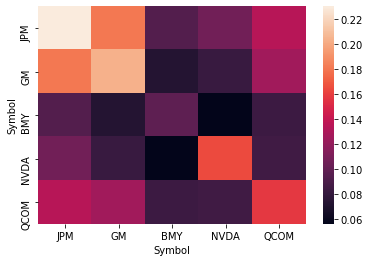

In [290]:
sns.heatmap(logChange.cov()*252)

#### get random portofolio weights to run simulations

In [291]:
np.random.seed(0)
weights = np.random.random(len(symbols))
weights /= np.sum(weights)
weights

array([0.19356424, 0.25224431, 0.21259213, 0.19217803, 0.14942128])

#### Expected return:
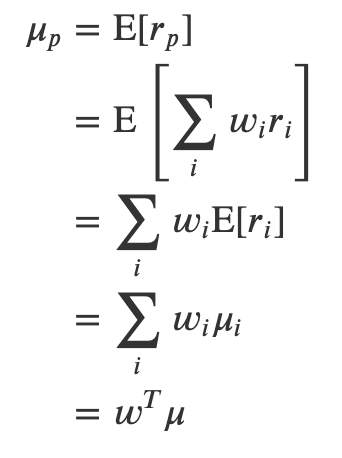

### expected return and volatility of porfolio with randomly assinged weights

In [292]:
#return of portfolio
np.sum(logChange.mean()*weights)*252

-0.9533658485094507

In [293]:
#variance of portfolio
np.dot(weights.T, np.dot(logChange.cov() * 252, weights))

0.11678255650890189

In [294]:
#standard deviation of portfolio (volatility)
np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))

0.341734628782191

## simulation of portfolios with different weight combinations

In [295]:
prets = []  #stores list of returns
pvols = []  #stores list of volatilities

for p in range (5000):
    weights = np.random.random(len(symbols))
    weights /= np.sum(weights)
    prets.append(np.sum(logChange.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(logChange.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

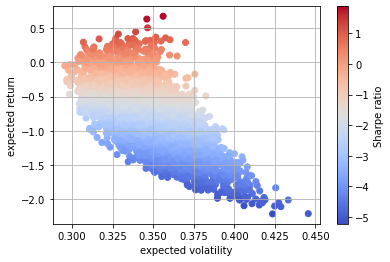

In [298]:

plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='coolwarm') # mpl.cm.jet)

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio') #beta
plt.show()

In [299]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
    
    Returns
    =======
    pret : float
    pvol : float
    pret / pvol : float      #sharp ratio (beta)

    '''
    riskfree = .0019   #risk free rate .19% (1 Year Treasury Rate is at 0.19%)
    weights = np.array(weights)
    pret = np.sum(logChange.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))
    return np.array([pret, pvol, ((pret-riskfree )/ pvol)])

### Sharp ratio optimization

In [300]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [301]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
cons

{'type': 'eq', 'fun': <function __main__.<lambda>(x)>}

In [302]:
#return, volatility, and sharp ratio when portfolio is weighted equally
w = len(symbols)*[1. /len(symbols),]
statistics(w)

array([-0.79677645,  0.34048026, -2.34573494])

In [303]:
bnds = tuple((0, 1) for x in range(len(symbols)))
bnds

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

In [304]:
#set initial point
len(symbols)* [1./len(symbols),]

[0.2, 0.2, 0.2, 0.2, 0.2]

#### Minimize a scalar function of one or more variables using Sequential Least Squares Programming (SLSQP).

#### scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

In [305]:
%%time

opts = sco.minimize(min_func_sharpe, len(symbols)* [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)


CPU times: user 18.4 ms, sys: 2.79 ms, total: 21.2 ms
Wall time: 18.5 ms


In [306]:
opts

     fun: -2.4391961601814183
     jac: array([ 7.55011043e+00,  7.52843440e+00,  2.01903012e+00, -4.68403101e-03,
        6.42280579e-02])
 message: 'Optimization terminated successfully.'
    nfev: 14
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([3.71924713e-15, 6.57807142e-15, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00])

In [307]:
a=opts['x'].round(3)   #opt weights
#print("exp return :" + str( np.sum(logChange.mean()*a)*252  )  ).round(3)   #1yr exp return of portfolio with opt weights 
print("exp return :" + str( statistics(opts['x'].round(3))[0].round(3) ) )
print("exp volatility :" + str( statistics(opts['x'].round(3))[1].round(3) )  )
print("exp sharp ratio :" + str( statistics(opts['x'].round(3))[2].round(3) )  )

exp return :0.991
exp volatility :0.406
exp sharp ratio :2.439


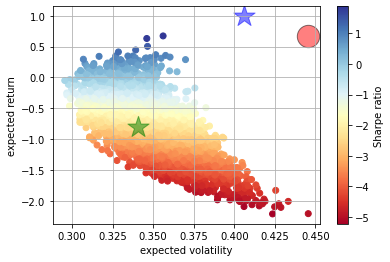

In [308]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='RdYlBu')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')


#return, volatility, and sharp ratio when portfolio is weighted equally
w = len(symbols)*[1. /len(symbols),]
plt.scatter(statistics(w)[1], statistics(w)[0], marker="*", s= 500, alpha=0.5, color='g')


# add a red dot for max_sr_vol & max_sr_ret
plt.scatter(pvols.max(), prets.max(), c='red', s=500, alpha=0.5, edgecolors='black')



plt.show()

### Volatility Optimization

In [309]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [310]:
optv = sco.minimize(min_func_variance,  len(symbols) * [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [311]:
optv

     fun: 0.08569486370894164
     jac: array([0.20864865, 0.17158043, 0.1713784 , 0.17135747, 0.17522054])
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([2.10337151e-17, 8.23304099e-02, 6.64210547e-01, 2.53459043e-01,
       9.29324905e-18])

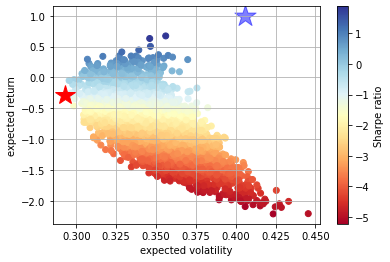

In [312]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='RdYlBu')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')

    
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')
            # Optimal (minimum) volatility
    
plt.show()

### Efficient Frontier

In [313]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [314]:
def min_func_port(weights):
    return statistics(weights)[1]

In [315]:
prets.min(), prets.max()

(-2.2126294326902647, 0.6720507780850319)

In [316]:
%%time
trets = np.linspace(prets.min(), max(prets.max(), pt_opts[0])  , 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, len(symbols)* [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 3.24 s, sys: 7.88 ms, total: 3.25 s
Wall time: 3.25 s


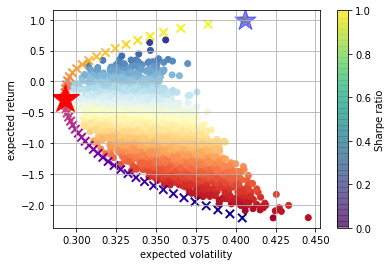

In [317]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap='RdYlBu')
            # rangdomly weighted sample portfolio simulations
    
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x', s=70, linewidth=2, cmap='plasma')
            # Efficient frontier
    
#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')

    
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=30, color='r')
            # Optimal (minimum) volatility
    
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

### Capital Market Line
Capital Asset Pricing Model, CAPM)

In [318]:
import scipy.interpolate as sci

In [319]:
np.argmin(tvols) #find index of minimum value of volatility 

30

In [320]:
ind = np.argmin(tvols)
evols = tvols[ind:]    #include array only up to the index of minimum volatility
erets = trets[ind:]

In [321]:
tck = sci.splrep(evols, erets)

In [322]:
def f(x):
    ''' efficient frontier (spline) '''
    return sci.splev(x, tck, der=0)

def df(x):
    ''' efficient frontier (first derivative)'''
    return sci.splev(x, tck, der=1)

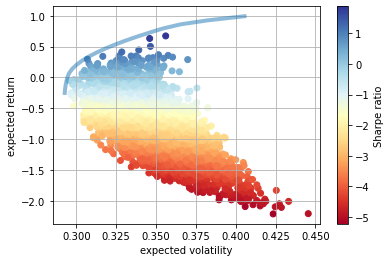

In [352]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap='RdYlBu')
            # randomly weighted sample portfolios 

plt.plot(evols, f(evols), lw=4, alpha=0.5)    

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [324]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [325]:
opt = sco.fsolve(equations, [0.01, 1.0, 0.1])
opt

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([0.01      , 2.66511906, 0.39165558])

In [326]:
np.round(equations(opt), 6)

array([ 0.      ,  0.103256, -0.040441])

In [355]:
erets, f(evols)

(array([-0.25122366, -0.18584347, -0.12046327, -0.05508308,  0.01029711,
         0.0756773 ,  0.1410575 ,  0.20643769,  0.27181788,  0.33719807,
         0.40257827,  0.46795846,  0.53333865,  0.59871884,  0.66409904,
         0.72947923,  0.79485942,  0.86023961,  0.92561981,  0.991     ]),
 array([-0.25122366, -0.18584347, -0.12046327, -0.05508308,  0.01029711,
         0.0756773 ,  0.1410575 ,  0.20643769,  0.27181788,  0.33719807,
         0.40257827,  0.46795846,  0.53333865,  0.59871884,  0.66409904,
         0.72947923,  0.79485942,  0.86023961,  0.92561981,  0.991     ]))

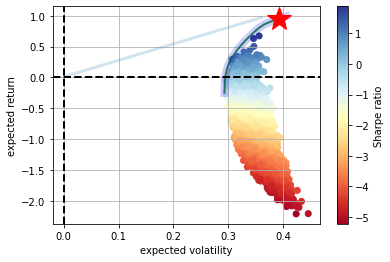

In [350]:

plt.scatter(pvols, prets,
            c= prets/pvols, marker='o', cmap='RdYlBu')
            # random sample portoflios

# efficient frontier
plt.plot(evols, erets, 'g', lw=2, alpha=.8)    
plt.plot(evols, f(evols), 'b', lw=8, alpha=0.2, )     


#Capital market line
cx = np.linspace(riskfree, 0.36 )   # (0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=3, alpha=0.2, ) 
    
    
plt.plot(opt[2], f(opt[2]), 'r*', markersize=25.0) 


plt.grid(True)
plt.axhline(0.0, color='k', ls='--', lw=2.0)
plt.axvline(0.0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

#### Optimal portfolio weights

In [330]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, len(symbols) * [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)
res['x'].round(3)

array([0.   , 0.   , 0.   , 0.919, 0.081])

#### return, volatility, and sharp ratio expected with the optimal weights

In [331]:
statistics(res['x'].round(3))

array([0.9505657 , 0.39080802, 2.42744683])

In [332]:
symbols

['JPM', 'GM', 'BMY', 'NVDA', 'QCOM']

In [333]:
summary_output = pd.DataFrame({'Symbol': symbols})
summary_output['Weight'] = res['x'].round(3)

In [334]:
summary_output = pd.merge(summary_output , (logChange.mean()*252).reset_index(name='temp'))

In [335]:
summary_output['Exp return'] = summary_output['Weight']*summary_output['temp']

In [336]:
summary_output = summary_output.pivot_table(index='Symbol', values=['Weight', 'Exp return']  , aggfunc=np.sum, margins=True)



In [337]:
summary_output

,Exp return,Weight
Symbol,,
BMY,0.000000,0.000
GM,0.000000,0.000
JPM,0.000000,0.000
NVDA,0.911023,0.919
QCOM,0.039543,0.081
All,0.950566,1.000


In [68]:
today = dt.datetime.today().strftime('%Y-%m-%d')
pdf_file_name = "Report "+ today +".pdf"

In [69]:
def PrepareTableForReportLab(dataframe):
    
    data = dataframe

    'handling grouped first index column'
    a= []
    for i in range(len(data)):
        #print(i, data.index.get_level_values(0)[i])
        if data.index.get_level_values(0)[i-1] == data.index.get_level_values(0)[i]:
            a.append(i)
    a.sort(reverse=True)

    as_list = data.index.get_level_values(0).tolist()
    for i in a:
        as_list[i] = ""

        
    'flat dataframe'
    data = data.reset_index()
    'remove duplicated values from first column which was index before resetting index'
    first_col_name = data.columns[0]
    data[first_col_name] = as_list 
    
    #data = dataframe.reset_index()
    #colwidths = 800/len(data.columns) 
    data = [data.columns.to_list()] + data.values.tolist() 

    #tbl = Table(data) # 
    tbl = Table(data) #, colwidths ) #, rowheights)
    tbl.setStyle(TableStyle([
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.black),
    ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
    ('BACKGROUND', (0,0), (-1,0), colors.Color(0,0.7,0.7))
    ]))
    
    return tbl

In [70]:
story = []

In [71]:
story.append(Paragraph("Portfolio", getSampleStyleSheet()['Heading1']))
story.append(PrepareTableForReportLab(summary_output))

story.append(PageBreak())

In [72]:
doc = SimpleDocTemplate(pdf_file_name, pagesize = landscape(letter), topMargin = inch * .25, bottomMargin = inch * .25)
doc.build(story)

In [73]:
#open folder
subprocess.run(['open', reportDir], check=True)

CompletedProcess(args=['open', '/Users/reejungkim/Documents/Git/reporting automation/2020-07-04 21-43-25'], returncode=0)

In [74]:
#Open pdf file generated
subprocess.run(['open', pdf_file_name], check=True)

CompletedProcess(args=['open', 'Report 2020-07-04.pdf'], returncode=0)